# Librerias, semilla y funciones 

In [1]:
############### Básicas ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')

############### sklearn ###############

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


############### Clasifiers ###############

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


############### Tratamiento ###############

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

############### Métricas ####################

from sklearn.metrics import accuracy_score, balanced_accuracy_score,average_precision_score, precision_recall_curve, recall_score, precision_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc


import scikitplot as skplt
import statsmodels.api as sm


############### Configuración ###############

os.chdir('/Users/josetunon/Desktop/ciencia_de_datos/aprendizaje_automatico/practica1_EDA/src')
import funciones as f
os.chdir('/Users/josetunon/Desktop/ciencia_de_datos/aprendizaje_automatico/practica1_EDA/notebooks')

seed=123
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)



In [2]:
df_train = pd.read_csv('../data/processed_data/df_train_scaled.csv')
df_test = pd.read_csv('../data/processed_data/df_test_scaled.csv')

# Separar las características y la variable objetivo
x_test = df_test.iloc[:, :-1]  # Todas las columnas excepto la última
y_test = df_test.iloc[:, -1]    # Última columna (variable objetivo)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(df_train.drop('TARGET', axis=1), df_train['TARGET'], 
                                                  test_size=0.2, random_state=seed  # 20% para validación
)

# 1. - Primera comparación de modelos (sin tratar desbalanceos)

In [3]:
# Lista de clasificadores 
classifiers = [
    DummyClassifier(strategy='most_frequent', random_state=seed),  # Clasificador simple
    LogisticRegression(random_state=seed, max_iter=1000),          # Asegurar convergencia
    GaussianNB(),                                                  # Determinista, no necesita random_state
    DecisionTreeClassifier(random_state=seed),                     # Árbol de decisión
    RandomForestClassifier(random_state=seed),                     # Random Forest
    XGBClassifier(random_state=seed, use_label_encoder=False),     # XGBoost
    LGBMClassifier(random_state=seed, force_row_wise=True)                              # LightGBM
]


In [5]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(x_train, y_train)   
    y_pred = pipe.predict(x_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(x_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier(random_state=123, strategy='most_frequent')
model score: 0.919

    accuracy = 0.9193935205885939
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45236     0]
 [ 3966     0]]
    
LogisticRegression(max_iter=1000, random_state=123)
model score: 0.920

    accuracy = 0.9195764399821146
    precision = 0.56
    recall = 0.01059001512859304
    f1_score = 0.02078693392724573
    confusion matrix:
    [[45203    33]
 [ 3924    42]]
    
GaussianNB()
model score: 0.758

    accuracy = 0.7578147229787408
    precision = 0.16158692320790055
    recall = 0.4785678265254665
    f1_score = 0.24159877800407328
    confusion matrix:
    [[35388  9848]
 [ 2068  1898]]
    
DecisionTreeClassifier(random_state=123)
model score: 0.851

    accuracy = 0.8505142067395635
    precision = 0.13985122210414452
    recall = 0.16591023701462432
    f1_score = 0.15177026871179794
    confusion matrix:
    [[41189  4047]
 [ 3308   658]]
    
RandomForestClassi

# 1.1. - GaussianNB - Naive Bayes

A priori de entre estos modelos vanilla el que mejor funciona es el Gaussiano. De base ya nos está dando un 50% de recall sacrificando un poco de precisión. El score que recibe es el más bajo de los modelos pero es el que mejor predice la clase minoritaria, que es lo que más le interesa a un banco, ser capaz de predecir que clientes no van a poder pagar, por ello vamos a seguir con el.



In [6]:
# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(x_train, y_train)

# Obtener el mejor modelo
gaussian_unbalanced_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = gaussian_unbalanced_model.predict(x_val)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred)  
f2_score = fbeta_score(y_val, y_pred, beta=2)  
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.825940159465814
Accuracy en el conjunto de validación: 0.7875
Recall en el conjunto de validación: 0.4334
F2-Score en el conjunto de validación: 0.3332


Hemos mejorado la precisión pero a cambio de recall. Hemos conseguido unos resultados bastante normalitos aún con el fine-tuning. El problema de este tipo de modelo es que al contar con muy pocos hiperparámetros, no va a mejorar demasiado según se combinen ya que hay pocas opciones. De todas formas voy a analizar las ventajas y dsventajas de este modelo buscando alguna forma de poder mejorar el resultado.

Ventajas: 
- Eficiencia computacional: Es extremadamente rápido de entrenar y predecir porque solo requiere el cálculo de estadísticas básicas.
- Escalabilidad: Escala bien con datos grandes.
- Interpretabilidad: Fácil de entender y explicar.
- Requiere pocos datos: Funciona bien con datasets pequeños o moderados.

Desvenatajas: 
- Se basa en que las variables son independientes --> revisar interdependencia de las variales 
- Requiere una distribución Gaussiana 
- Sensibilidad a los valores atípicos 

Viendo estas limitaciones que tiene, es conveniente revisar si nuestros datos de adaptan bien a ellas.Estas 2 últimas limitaciones ya se solucionaron con el procesos de estandarización que realizamos en '03_Feature_Processing.ipynb', por lo que no debería suponer un problema. En cuanto a la independencia de las varaibles había algunas que estaban muy correlacionadas cuando lo estudiamos en el notebook 2.

Por esto vamos revisar correlaciones e independencias y valorar posteriormente la eliminación de algunas variables y ver si así el resultdao mejora.


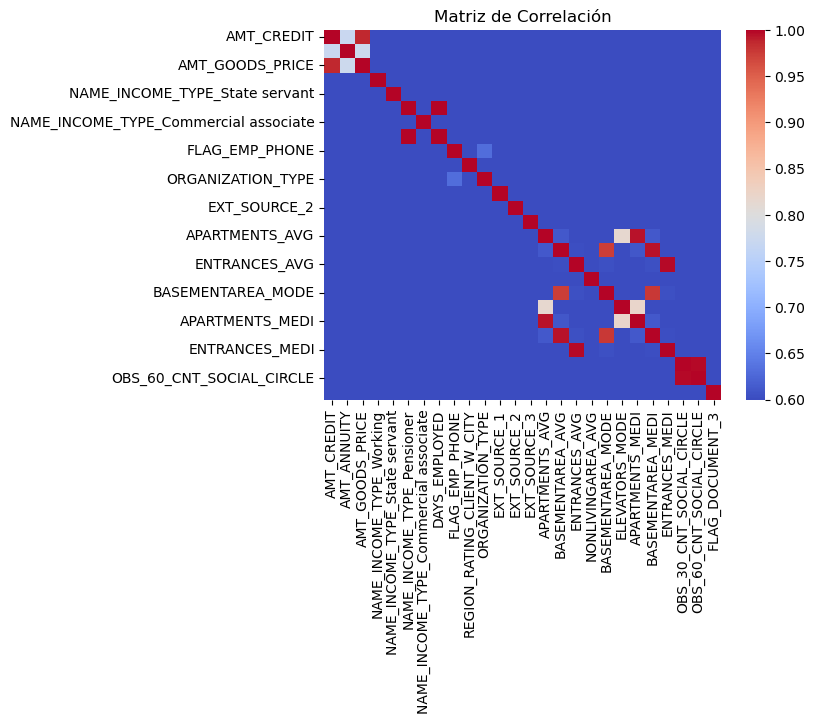

In [7]:
correlation_matrix = x_train.corr()
sns.heatmap(correlation_matrix, annot=False, vmin=0.6, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [8]:
new_corr = correlation_matrix.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

,level_0,level_1,correlation
215,FLAG_EMP_PHONE,DAYS_EMPLOYED,0.999783
213,FLAG_EMP_PHONE,NAME_INCOME_TYPE_Pensioner,0.999467
187,DAYS_EMPLOYED,NAME_INCOME_TYPE_Pensioner,0.999454
647,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998367
588,ENTRANCES_MEDI,ENTRANCES_AVG,0.996907
534,APARTMENTS_MEDI,APARTMENTS_AVG,0.995091
561,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,0.994510
52,AMT_GOODS_PRICE,AMT_CREDIT,0.986529
564,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,0.977954
483,BASEMENTAREA_MODE,BASEMENTAREA_AVG,0.973641


Como se puede ver hay unas cuantas variables que están relacionadas casi al 100%. Voy a ir seleccionando en cada pareja de variables la que voy a eliminar en función de: 
- Cual es más difícil de interpretar --> 'FLAG_EMP_PHONE'
- Que información es menos útil, por ejemplo he decidod eliminar lo casos de '_MODE'

Después de realizar esto, voy a volver a tirar el modelo y evaluaré si existe algún tipo de mejora

In [9]:
lista_eliminar = ['FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ENTRANCES_MEDI', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                  'AMT_GOODS_PRICE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MODE']

# Eliminar columnas del conjunto de entrenamiento y prueba
x_train_reduced = x_train.drop(columns=lista_eliminar)
x_test_reduced = x_test.drop(columns=lista_eliminar)
x_val_reduced = x_val.drop(columns=lista_eliminar)

assert list(x_train_reduced.columns) == list(x_test_reduced.columns), "Los conjuntos no tienen las mismas columnas."

In [10]:
# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(x_train_reduced, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_model.predict(x_val_reduced)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred,) 
f2_score = fbeta_score(y_val, y_pred, beta=2) 
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.8812199580170471
Accuracy en el conjunto de validación: 0.8824
Recall en el conjunto de validación: 0.2148
F2-Score en el conjunto de validación: 0.2197

Matriz de confusión:
[[42562  2674]
 [ 3114   852]]


Los resultados conseguidos tras eliminar las columnas dependientes han empeorado claramente. La precisión ha aumentado en 7 puntos pero el recall, la medida objetivo, se ha desplomado. Voy a dejar este modelo aquí porque no veo forma de poder mejorarlo. 

Es un modelo simple que de primeras ha dado unos resultados que parecian buenos. El problema que presenta es precisamente eso, su simpleza, al no tener parámetros que ayuden a que se adapte a cada caso hace que la cantidad de mejora sea muy baja.

En base a esto y analizando un poco cada modelo, el que trataría de optimizar ahora es el XGBoost. Pero viendo los malos resultados a nivel general, voy a considerar hacer previamente un balanceo.

# 2. - Oversampling y undersampling

Me he dado cuenta de que, en este caso, y probablemente en muchos otros, es imprescindible tratar el desbalanceo de las clases. Los modelos que se generan con datos tan desbalanceados resultan prácticamente inútiles, ya que tienden a sobreajustarse incluso con pequeños ajustes en los hiperparámetros. Esto no solo afecta el rendimiento del modelo, sino que limita significativamente su capacidad de generalización.

Por tanto, trabajar directamente con datos desbalanceados como los actuales no es una opción viable. Para abordar este problema, voy a aplicar técnicas de undersampling y oversampling, que son los enfoques más utilizados en este tipo de situaciones. Considero que, dado el grado de desbalanceo en los datos, será necesario utilizar una combinación de ambos métodos para lograr un balance adecuado entre las clases.

El objetivo de este enfoque es reducir el riesgo de sobreajuste que surge al intentar entrenar modelos con datos altamente desbalanceados, mientras se mantiene suficiente información en el conjunto de datos para que el modelo pueda aprender patrones significativos. Por lo tanto, procederé a implementar estas técnicas y evaluar su impacto en el rendimiento del modelo.

El desbalanceo se trata principalemente mediante técnidas de oversampling y undersampling.
- Oversampling. Consiste en aumentar la cantidad de muestras de la clase minoritaria replicándolas o generando nuevas muestras sintéticas.
    - Random Oversampling: Duplica aleatoriamente las muestras de la clase minoritaria.
    - SMOTE (Synthetic Minority Oversampling Technique): Genera muestras sintéticas interpolando entre instancias cercanas de la clase minoritaria.
    - ADASYN (Adaptive Synthetic Sampling): Similar a SMOTE, pero genera más muestras sintéticas en regiones con menor densidad.

- Undersampling. Consiste en reducir el número de muestras de la clase mayoritaria eliminando instancias de forma aleatoria o estructurada.
    - Random Undersampling: Elimina muestras aleatorias de la clase mayoritaria.
    - Tomek Links: Identifica pares de muestras de clases opuestas que están muy cercanas y elimina la muestra mayoritaria.
    - NearMiss: Selecciona muestras de la clase mayoritaria que están más cerca de las de la clase minoritaria.

En este caso debido al desbalanceo tan grande que hay (sólo un 8.07% de la clase minoritaria) voy a usar ambos métodos. Primero voy a generar datos sintéticos mediante SMOTE porque me parece que es el que mejor se puede adaptar a este caso. Ya que Randomo Oversampling añade un componenente de aleatoriedad que creo que empeorará las predicciones del modelo y con la cantidad total de datos que tenemos, crear datos sintéticos no va a alterar la información en exceso.

Después lo que haré será aplicar un 'RandomSampler' para eliminar de forma aleatoria instancias de la clase mayoritaria. Con esto pretendo conseguir un cierto balanceo de las clases para evitar que el modelo se centre en aprender solo una de las clases.

Para llegar a esta conclusión e ido incrementando progresivamente el balanceo mientras comprobaba como mejoraban las predicciones de los modelos vanilla. Después de realizar considerables pruebas, he encontrado este punto en el que consigo mejores resultados sin incrementar en exceso del balanceo de la clase minoritaria.

In [4]:
# Configurar SMOTE
smote = SMOTE(
    sampling_strategy=0.4,  # La clase minoritaria será el 50% de la mayoritaria
    k_neighbors=4,          # Usar 4 vecinos para interpolación
    random_state=seed,        # Reproducibilidad
    n_jobs=-1               # Usar todos los núcleos disponibles
)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
y_train_resampled.value_counts()/ len(y_train_resampled)


TARGET
0    0.714288
1    0.285712
Name: count, dtype: float64

In [5]:
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=seed)
x_resampled, y_resampled = undersampler.fit_resample(x_train_resampled, y_train_resampled)
values = y_resampled.value_counts()/len(y_resampled)

print(len(y_train))
print(len(y_train_resampled))
print(len(y_resampled))
print(values)

196806
253276
192970
TARGET
0    0.624999
1    0.375001
Name: count, dtype: float64


Al final he llegado a esta combinación de resultados en la que la clase minoritaria llega a ser un 37%.5, a este punto he llegado con:
 - 56.406 observaciones creadas mediante 'SMOTE'
 - 60.290 observaciones (con y = 0) eliminadas mediante 'RandomUnderSampler'


# 3. - Evaluación modelos (clases balanceadas)

# 3.1. - Modelos Vanilla

In [13]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(x_resampled, y_resampled)   
    y_pred = pipe.predict(x_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(x_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier(random_state=123, strategy='most_frequent')
model score: 0.919

    accuracy = 0.9193935205885939
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45236     0]
 [ 3966     0]]
    
LogisticRegression(max_iter=1000, random_state=123)
model score: 0.812

    accuracy = 0.8119791878378928
    precision = 0.2011760714689585
    recall = 0.4485627836611195
    f1_score = 0.2777734405496135
    confusion matrix:
    [[38172  7064]
 [ 2187  1779]]
    
GaussianNB()
model score: 0.485

    accuracy = 0.4850209341083696
    precision = 0.10509977827050998
    recall = 0.7170953101361573
    f1_score = 0.18333011023012957
    confusion matrix:
    [[21020 24216]
 [ 1122  2844]]
    
DecisionTreeClassifier(random_state=123)
model score: 0.777

    accuracy = 0.7773870980854437
    precision = 0.1190709846254498
    recall = 0.2753403933434191
    f1_score = 0.1662480018269011
    confusion matrix:
    [[37157  8079]
 [ 2874  1092]]
    
RandomFor

# 3.2. - Modelos candidatos

# 3.2.1 - Logistic Regresion

La regresión logística es un modelo de clasificación que predice la probabilidad de que una muestra pertenezca a una clase específica. Primero, combina las características de entrada mediante una fórmula lineal: 
𝑧 = 𝑤^𝑇 * 𝑋 + 𝑏. Este valor se transforma en una probabilidad usando la función sigmoide: 𝜎(𝑧)= 1/ (1+𝑒^−𝑧), que siempre produce valores entre 0 y 1. 

El modelo clasifica la muestra según un umbral, generalmente 0.5, asignándola a la clase positiva si la probabilidad es mayor o igual a este umbral. Durante el entrenamiento, ajusta los pesos y el sesgo para minimizar el error en las predicciones, utilizando una función de pérdida llamada log-loss. Este enfoque permite capturar relaciones lineales entre las características y la clase objetivo, siendo una herramienta simple, eficiente y fácil de interpretar.

In [ ]:
# Configurar el Pipeline
lr_pipeline = Pipeline(steps=[('classifier', LogisticRegression(random_state=seed, max_iter=1000))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__C': [0.88, 0.89, 0.9, 0.91, 0.92],         # Coeficiente de regularización
    'classifier__penalty': ['l1'],                          # Tipo de regularización
    'classifier__solver': [ 'saga'],                        # Solvers compatibles con regularización
    'classifier__l1_ratio': [0.23, 0.24, 0.25, 0.26, 0.27]  # Solo para 'elasticnet'
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring=make_scorer(f1_score, average='weighted'),  # Métrica de evaluación
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)
y_pred = CV.predict(x_val)

# Almacenar modelo y mejores parámetros
logistic_model = CV.best_estimator_
best_params_lr = CV.best_params_

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

# Reporte de clasificación
print(classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(CV, X_val, y_val,
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title('Normalizada')

print(disp.confusion_matrix)





Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elastic

[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elastic

[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/o

[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  war

[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min
Mejores parámetros: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.23, 'classifier__C': 0.89}
Mejor score: 0.6873037195250237
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     45282
           1       0.20      0.46      0.28      3920

    accuracy                           0.81     49202
   macro avg       0.57      0.65      0.59     49202
weighted avg       0.89      0.81      0.84     49202



# **Reejecutar esta celda**

[[0.95808489 0.04191511]
 [0.82908163 0.17091837]]


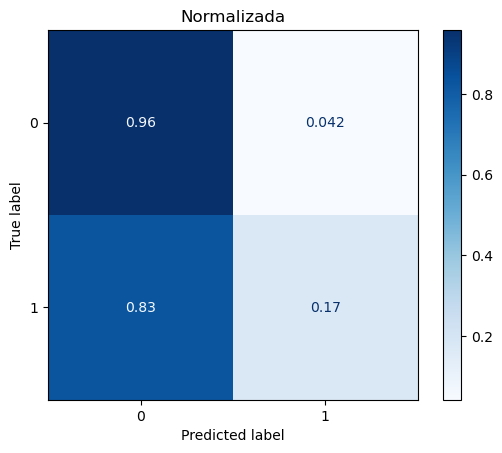

In [ ]:

best_params_rl = {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.23, 'classifier__C': 0.89}



# 3.2.2 - Árbol de decisión

Un Árbol de Decisión es un modelo de machine learning interpretable utilizado tanto para clasificación como para regresión. Su estructura se asemeja a un árbol, donde cada nodo interno representa una decisión basada en una característica, cada rama representa un resultado posible, y cada hoja representa una predicción (una clase o un valor).

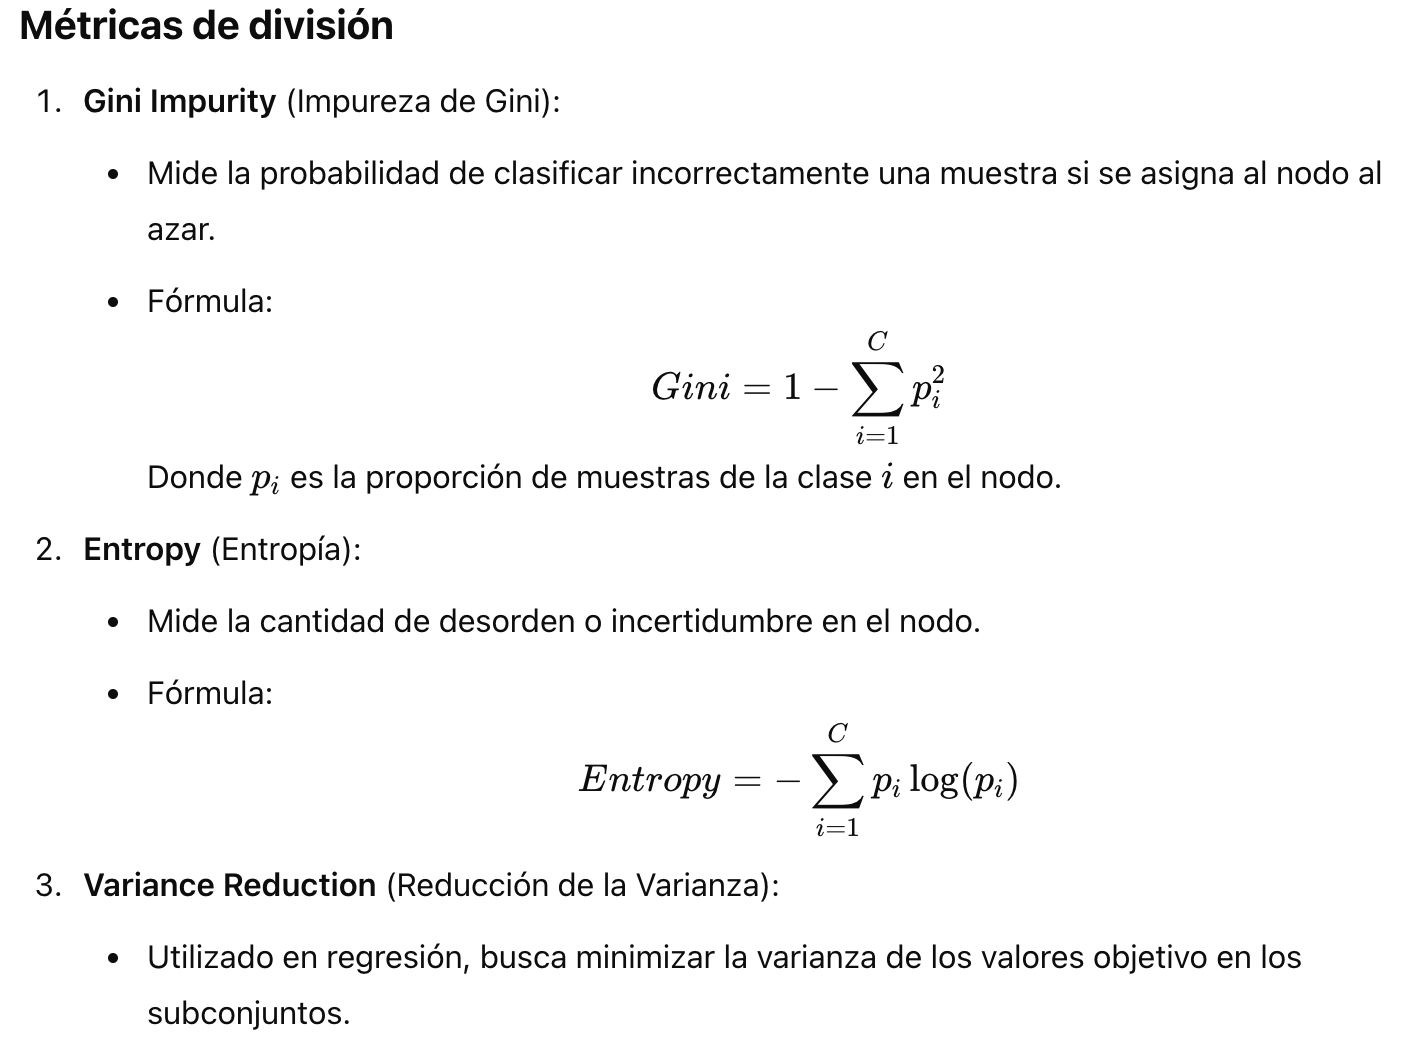

Ventajas

- Interpretabilidad: Fácil de entender y visualizar.
- Flexible: Puede manejar datos categóricos y numéricos.
- No requiere normalización: No depende de la escala de las características.
- Captura interacciones: Puede identificar automáticamente interacciones entre características.

Limitaciones
- Sobreajuste: Los árboles profundos tienden a memorizar los datos de entrenamiento.
    - Mitigación: Limitar la profundidad del árbol o usar poda.
- Inestabilidad: Pequeños cambios en los datos pueden generar estructuras de árbol diferentes.

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores parámetros: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_leaf_nodes': None, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Mejor score (validación cruzada): 0.5469436419354787

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     45236
           1       0.15      0.35      0.21      3966

    accuracy                           0.78     49202
   macro avg       0.54      0.59      0.54     49202
weighted avg       0.87      0.78      0.82     49202



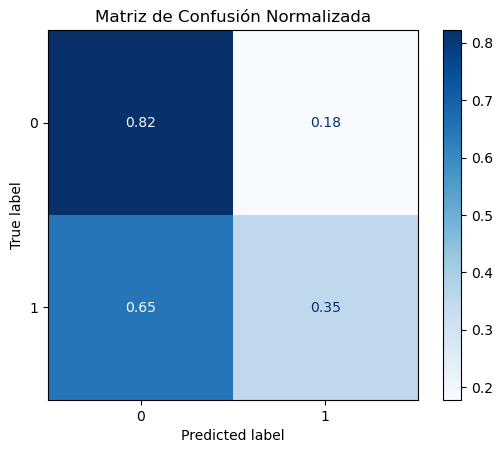


Matriz de confusión (normalizada):
[[0.82184543 0.17815457]
 [0.64977307 0.35022693]]


In [6]:
# Configurar el Pipeline
dt_pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=seed))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],         # Función de evaluación para los nodos
    'classifier__max_depth': [3, 5, 10, None],           # Profundidad máxima del árbol
    'classifier__min_samples_split': [2, 5, 10],         # Número mínimo de muestras para dividir un nodo
    'classifier__min_samples_leaf': [1, 2, 4],           # Número mínimo de muestras en una hoja
    'classifier__max_features': [None, 'sqrt', 'log2'],  # Número máximo de características a considerar
    'classifier__max_leaf_nodes': [None, 10, 20, 50],    # Número máximo de nodos hoja
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring= make_scorer(f1_score), 
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1   # Para que nose vaya viendo cada innstacia que calcula el modelo 
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)

y_pred = CV.predict(x_val)
best_dt = CV.best_params_

f.fast_eval(CV, x_val, y_val, y_pred)

# 3.2.4. - LightGMB

LightGBM (Light Gradient Boosting Machine) es un modelo de aprendizaje automático basado en boosting que utiliza árboles de decisión como predictores. Funciona de manera iterativa, donde cada árbol trata de corregir los errores del conjunto anterior, optimizando una función de pérdida.



[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 w

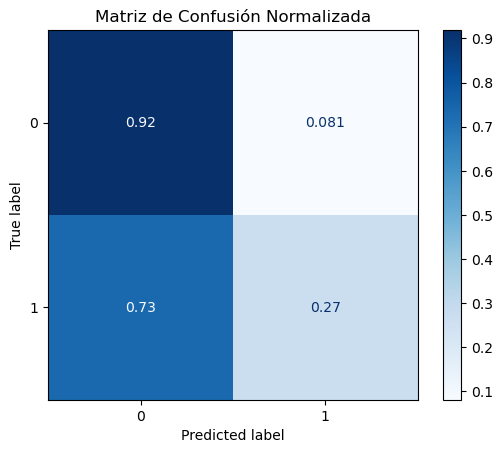


Matriz de confusión (normalizada):
[[0.91889203 0.08110797]
 [0.73474534 0.26525466]]


In [9]:
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# Configurar el Pipeline
lgbm_pipeline = Pipeline(steps=[('classifier', LGBMClassifier(random_state=seed, class_weight='balanced'))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__n_estimators': [230, 250, 270],       # Número de árboles
    'classifier__max_depth': [6, 7, 8],           # Profundidad máxima (-1 para sin límite)
    'classifier__learning_rate': [0.08, 0.09, 0.1],   # Tasa de aprendizaje
    'classifier__subsample': [0.6, 0.8, 1.0],         # Fracción de datos para cada árbol
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],  # Fracción de características para cada árbol
    'classifier__min_child_samples': [25, 30, 35],    # Muestras mínimas en una hoja
    'classifier__num_leaves': [31, 34, 36],          # Número máximo de hojas en un árbol
    'classifier__lambda_l1': [0.0, 0.05, 0.1],          # Regularización L1
    'classifier__lambda_l2': [0.0, 0.05, 0.1], 
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose= 0 # Lo pongo así para no ensuciar el notebook final --> 0 mensajes
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)

# Almacenos el modelo y los mejores parámetros 
lghtgbm_model = CV.best_estimator_
lightgbm_best_params = CV.best_params_

f.fast_eval(CV, x_val, y_val, y_pred)

In [ ]:
y_pred_proba = CV.predict_proba(x_val)[:, 1]
threshold = 0.35  # Prueba valores como 0.3 o 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

# 3.2.5. - GaussianNB()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros: {'var_smoothing': 1e-12}
Mejor score (validación cruzada): 0.5683992330414054

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.46      0.62     45236
           1       0.11      0.72      0.18      3966

    accuracy                           0.49     49202
   macro avg       0.53      0.59      0.40     49202
weighted avg       0.88      0.49      0.59     49202



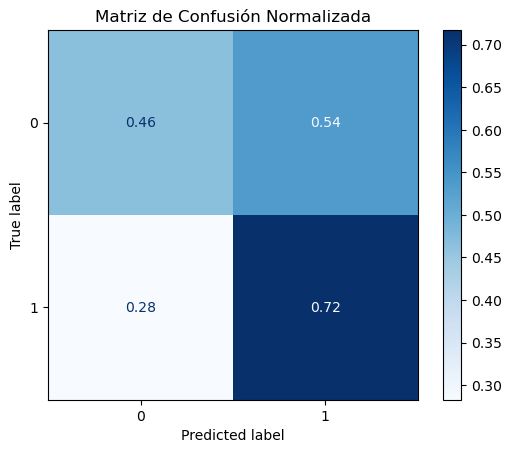


Matriz de confusión (normalizada):
[[0.46467415 0.53532585]
 [0.28290469 0.71709531]]


In [ ]:
# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
CV = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring= 'accuracy',
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
CV.fit(x_resampled, y_resampled)

## Obtener el mejor modelo y predecir en el conjunto de validación
y_pred = CV.predict(x_val)
gaussian_model = grid_search.best_estimator_

f.fast_eval(CV, x_val, y_val, y_pred)

# 3.2.3. - XGBClassifier

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores parámetros: {'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 4, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.9}
Mejor score (validación cruzada): 0.7185114167085442

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     45236
           1       0.15      0.35      0.21      3966

    accuracy                           0.78     49202
   macro avg       0.54      0.59      0.54     49202
weighted avg       0.87      0.78      0.82     49202



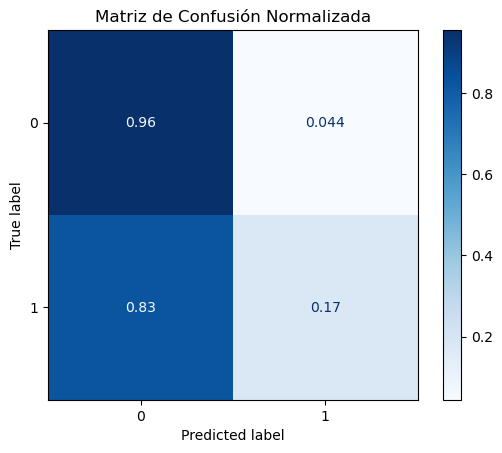


Matriz de confusión (normalizada):
[[0.95567689 0.04432311]
 [0.82526475 0.17473525]]


In [ ]:
# Configurar el Pipeline
xgb_pipeline = Pipeline(steps=[('classifier', XGBClassifier( eval_metric='logloss'))])

# Definir el espacio de hiperparámetros

param_grid = {
    'classifier__n_estimators': [300],
    'classifier__max_depth': [ 4, 5, 6],                 # Poca profundidad --> evitar overfitting
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],           # Fracción de datos usados por cada árbol
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],    #  Fracción de características usadas por árbol
    'classifier__min_child_weight': [4, 5, 6],
    'classifier__gamma': [0.09, 0.1, 0.11],
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring= make_scorer(recall_score),
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)

CV.predict(x_val)
## Almaceno los mejores parámetros 
xgb_model = CV.best_estimator_
best_params_xgb = CV.best_params_

f.fast_eval(CV, x_val, y_val, y_pred)

In [ ]:
print(CV.estimator)

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


Text(45.722222222222214, 0.5, 'Actual')

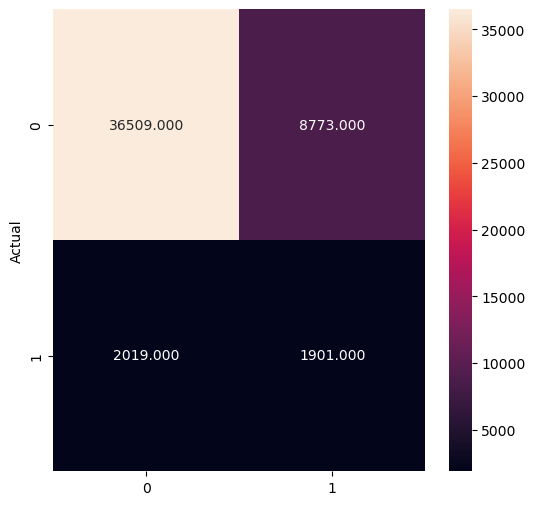

In [ ]:
prob_predictions = CV.predict_proba(X_val)

cm = confusion_matrix(y_val, y_pred)


print(CV.estimator)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.3f')
plt.ylabel('Actual')

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
Confusion matrix, without normalization
[[41818  3464]
 [ 2856  1064]]
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
Normalized confusion matrix
[[0.92350161 0.07649839]
 [0.72857143 0.27142857]]


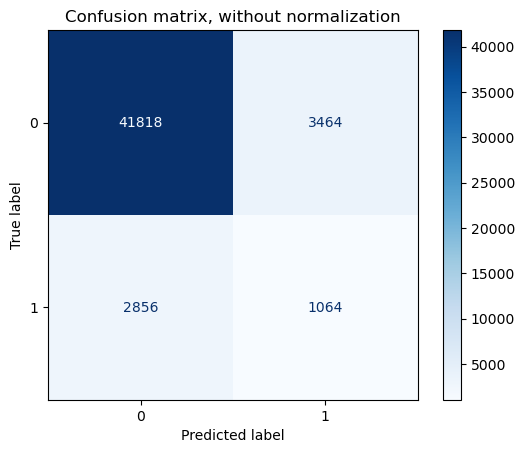

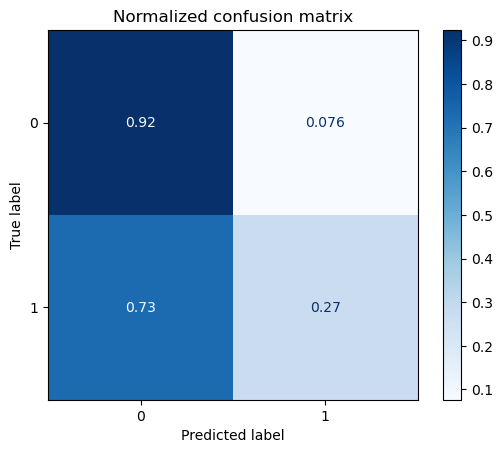

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
print(CV.estimator)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(CV, X_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


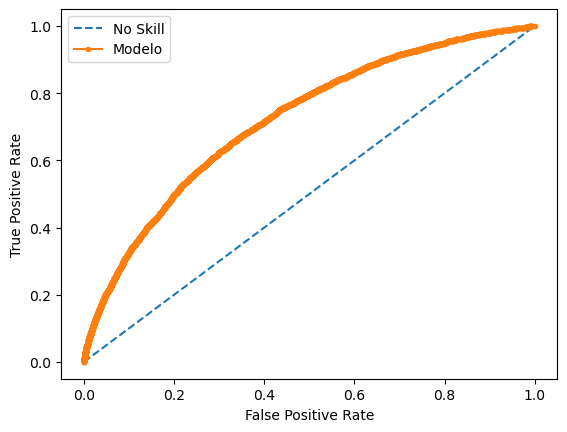

In [78]:
print(CV.estimator)

# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=f'Modelo')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [70]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.255536, G-Mean=0.662


Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


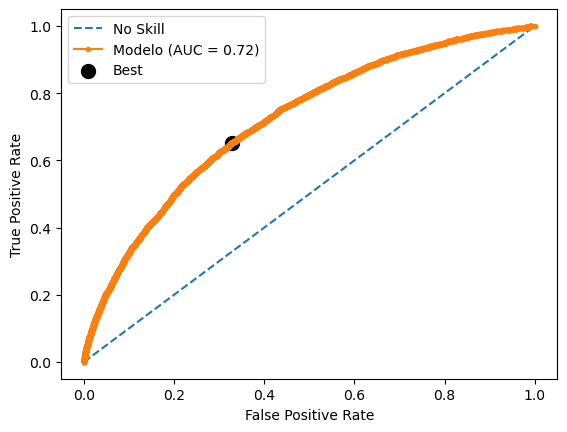

In [80]:
print(CV.estimator)

# calculate AUC
roc_auc = roc_auc_score(y_val, yhat)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')    ## Caso de aleatoriedad
plt.plot(fpr, tpr, marker='.', label=f'Modelo (AUC = {roc_auc:.2f})')   
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Precision Curve

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


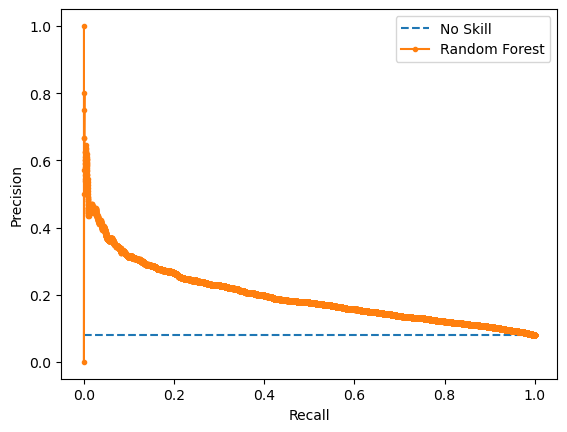

In [81]:
print(CV.estimator)

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, yhat)

# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


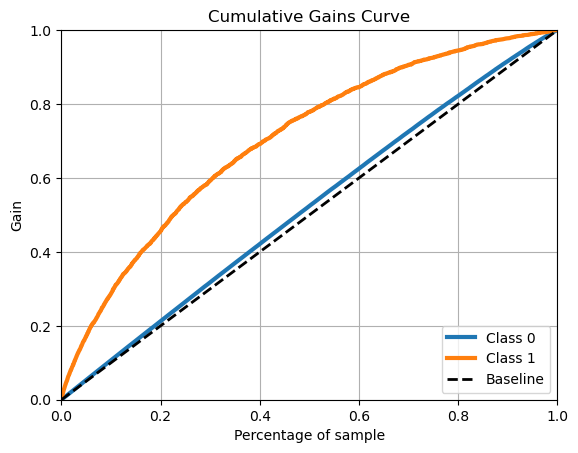

In [ ]:
print(CV.estimator)
skplt.metrics.plot_cumulative_gain(y_val, prob_predictions)
plt.show()

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


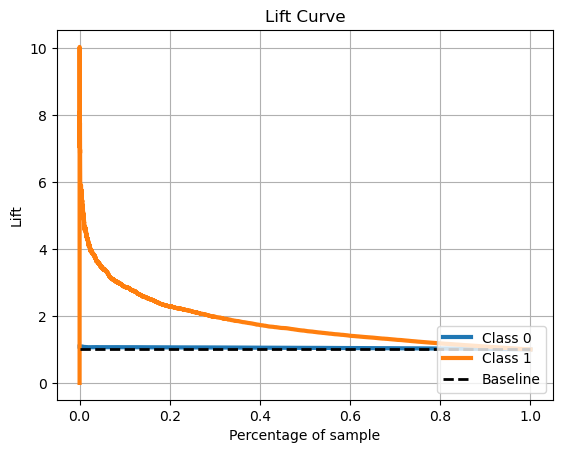

In [84]:
print(CV.estimator)
skplt.metrics.plot_lift_curve(y_val, prob_predictions)
plt.show()

# 4. - Selección modelo final

[[0.84576653 0.15423347]
 [0.54897959 0.45102041]]


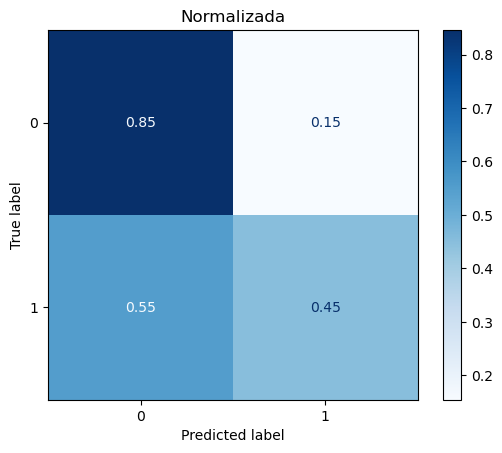

In [39]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo con los parámetros óptimos
logistic_model = LogisticRegression(
    C=best_params_rl['classifier__C'],
    penalty=best_params_rl['classifier__penalty'],
    solver=best_params_rl['classifier__solver'],
    l1_ratio= best_params_rl['classifier__l1_ratio'],
    random_state=seed
)

# Entrenar el modelo con los datos
logistic_model.fit(X_resampled, y_resampled)

# Hacer predicciones con el modelo entrenado
y_pred = logistic_model.predict(X_val)

disp = ConfusionMatrixDisplay.from_estimator(logistic_model, X_val, y_val,
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title('Normalizada')

print(disp.confusion_matrix)

In [ ]:
## Guardamos el modelo ajustado para analizarlo en el siguiente notebook
from joblib import dump

# Guardar el objeto en el archivo especificado
dump(logistic_model, '../modelos/regresionlog.joblib')

['../modelos/regresionlog.joblib']